In [104]:
from __future__ import unicode_literals, print_function, division
import random
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.nn.functional as F
import time
from utils import timeSince

from cn_cn_data import get_cn_en_padded_loader, cn_vocab, en_vocab


In [105]:
seq_len = 15
max_length = seq_len + 2
batch_size = 4

cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)

device = torch.device("cpu")
train_loader, train_dataset = get_cn_en_padded_loader(seq_len, batch_size, device)
print('length of train_loader', len(train_loader))

length of train_loader 552


In [106]:
for i, item in enumerate(train_loader):
    print(item[0][0].shape, item[1].shape)
    print([idx[0].item() for idx in item[0][0]])
    print([idx[0].item() for idx in item[1]])

    print(item[0][1])
    break

torch.Size([11, 4]) torch.Size([8, 4])
[2, 19, 164, 14, 313, 47, 1671, 168, 172, 5, 3]
[2, 131, 262, 86, 1096, 454, 5, 3]
tensor([11,  9,  8,  7])


In [107]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, input_lengths):
        embedded = self.dropout(self.embedding(input))
        #need to explicitly put lengths on cpu!
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.to('cpu'))

        #packed_outputs is a packed sequence containing all hidden states, hidden is now from the final non-padded element in the batch
        packed_outputs, hidden = self.gru(embedded)

        #outputs is now a non-packed sequence, all hidden states obtained, when the input is a pad token are all zeros
        # outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        return packed_outputs, hidden


In [108]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden, encoder_outputs, mask):
        seq_len = encoder_outputs.size(1)

        hidden = hidden.permute(1, 0, 2)
        # repeat decoder hidden state src_len times, hidden = [batch, seq_len, hidden size]
        hidden = hidden.repeat(1, seq_len, 1)

        # [batch, seq_len, hidden size * 2]
        outputs_cat_hidden = torch.cat((hidden, encoder_outputs), dim=2)

        # energy = [batch, seq_len, hidden size]
        energy = torch.tanh(self.attn(outputs_cat_hidden))

        # attention= [batch, seq_len]
        attention = self.v(energy).squeeze(2)

        # attention = attention.masked_fill(mask == 0, -1e10)

        return self.softmax(attention)


In [109]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.attention = Attention(hidden_size)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.GRU(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size * 3, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):
        # input = [batch, 1]
        # hidden = [1, batch, hidden_size]
        #mask = [batch size, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch, seq_len, hidden size]
        # embedded = [1, batch, hidden_size]
        embedded = self.dropout(self.embedding(input)).unsqueeze(0)

        # [batch, 1, seq_len]
        attention = self.attention(hidden, encoder_outputs, mask).unsqueeze(1)

        # weighted = [batch, 1, hidden_size]
        weighted_encoder_outputs = torch.bmm(attention, encoder_outputs).permute(1, 0, 2) # (1, batch, hidden_size)

        # output = [seq_len, batch, hidden_size], hidden = [n_layers(1), batch, hidden_size]
        output, hidden = self.rnn(torch.cat((embedded, weighted_encoder_outputs), dim=2), hidden)

        embedded = embedded.squeeze(0) # [batch, hidden_size]
        output = output.squeeze(0) # [batch, hidden_size]
        weighted_encoder_outputs = weighted_encoder_outputs.squeeze(0) # [batch, hidden_size]

        prediction = self.out(torch.cat((output, weighted_encoder_outputs, embedded), dim=1)) # [batch, output _ize]
        return prediction, hidden, attention.squeeze(1)


In [110]:
teacher_forcing_ratio = 0.5

def create_mask(input):
    mask = (input != cn_vocab['<pad>']).permute(1, 0)
    return mask

def train(input, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(0)
    loss = 0

    (input_tensor, input_lengths) = input
    encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)

    decoder_input = input_tensor[0]
    decoder_hidden = encoder_hidden

    mask = create_mask(input_tensor)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, mask)

            target = target_tensor[di]
            loss += criterion(decoder_output, target)
            decoder_input = target  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, mask)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()  # detach from history as input

            target = target_tensor[di]
            loss += criterion(decoder_output, target)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [111]:
def trainIters(encoder, decoder, train_loader, print_every=100, plot_every=10, learning_rate=0.005):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss(ignore_index=en_vocab['<pad>'])
    n_iters = len(train_loader)

    for iter, data in enumerate(train_loader, 1):
        input, target_tensor = data

        loss = train(input, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [112]:
hidden_size = 256
encoder1 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder1 = Decoder(hidden_size, en_vocab_size).to(device)

train_losses = []
for i in range(15):
    print('--------------epoch %d--------------' % (i + 1))
    losses = trainIters(encoder1, decoder1, train_loader, print_every=100)
    train_losses = train_losses + losses

--------------epoch 1--------------
0m 11s (- 0m 50s) (100 18%) 5.3750
0m 22s (- 0m 39s) (200 36%) 3.8763
0m 34s (- 0m 28s) (300 54%) 3.6757
0m 45s (- 0m 17s) (400 72%) 3.6063
0m 56s (- 0m 5s) (500 90%) 3.4253
--------------epoch 2--------------
0m 10s (- 0m 49s) (100 18%) 3.2983
0m 21s (- 0m 38s) (200 36%) 3.2562
0m 32s (- 0m 27s) (300 54%) 3.3798
0m 44s (- 0m 16s) (400 72%) 3.3093
0m 54s (- 0m 5s) (500 90%) 3.2075
--------------epoch 3--------------
0m 11s (- 0m 50s) (100 18%) 3.1483
0m 21s (- 0m 38s) (200 36%) 3.1167
0m 32s (- 0m 27s) (300 54%) 3.0664
0m 43s (- 0m 16s) (400 72%) 3.2287
0m 54s (- 0m 5s) (500 90%) 3.1580
--------------epoch 4--------------
0m 10s (- 0m 48s) (100 18%) 2.9801
0m 21s (- 0m 38s) (200 36%) 3.0649
0m 32s (- 0m 27s) (300 54%) 3.2018
0m 43s (- 0m 16s) (400 72%) 2.9874
0m 54s (- 0m 5s) (500 90%) 2.9993
--------------epoch 5--------------
0m 11s (- 0m 50s) (100 18%) 3.0385
0m 22s (- 0m 38s) (200 36%) 2.9919
0m 32s (- 0m 27s) (300 54%) 3.0343
0m 43s (- 0m 16s) (

<Figure size 640x480 with 0 Axes>

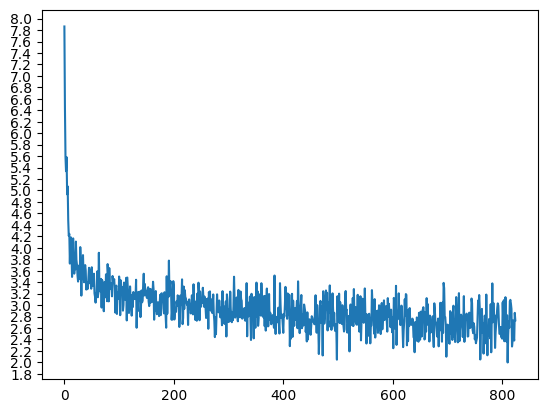

In [113]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [114]:
encoder_path = './models/seq2seq6-encoder.pt'
decoder_path = './models/seq2seq6-decoder.pt'


In [115]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)


In [116]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = train_dataset.tokenize_sentence(sentence, True).unsqueeze(0)
        input_tensor = input_tensor.permute(1, 0)
        input_length = input_tensor.size(0)
        input_lengths = torch.tensor([len(input_tensor)])

        mask = create_mask(input_tensor)

        encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)

        decoder_input = torch.tensor([cn_vocab['<sos>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, mask)
            topv, topi = decoder_output.data.topk(1)
            decoder_attentions[di] = decoder_attention.squeeze().data
            if topi.item() == en_vocab['<eos>']:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_vocab.lookup_token(topi.item()))

            decoder_input = topi.squeeze(1).detach()

        return decoded_words[1:], decoder_attentions[:di + 1]


In [117]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [118]:
encoder2 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder2 = Decoder(hidden_size, en_vocab_size).to(device)

encoder2.load_state_dict(torch.load(encoder_path))
decoder2.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

In [119]:
evaluateRandomly(encoder2, decoder2)


> 我单身。
= I'm unmarried.
< I 'm a to . <EOS>

> 你开车很好。
= You're a good driver.
< You 're a to . <EOS>

> 我希望那会发生。
= I'm hoping that that'll happen.
< I 'm a to <EOS>

> 我是个英雄。
= I'm a hero.
< I 'm a to <EOS>

> 我完全地筋疲力尽了。
= I'm completely exhausted.
< I 'm not to <EOS>

> 我等着你帮我。
= I'm waiting for you to help me.
< I 'm not to <EOS>

> 我现在在打排球。
= I am playing volleyball now.
< I 'm not . <EOS>

> 他决心去英国。
= He is determined to go to England.
< He 's a of . <EOS>

> 你不够快。
= You're not fast enough.
< You 're a to <EOS>

> 她是汤姆的妹妹。
= She's Tom's younger sister.
< She 's a to <EOS>



I 'm not to . <EOS>


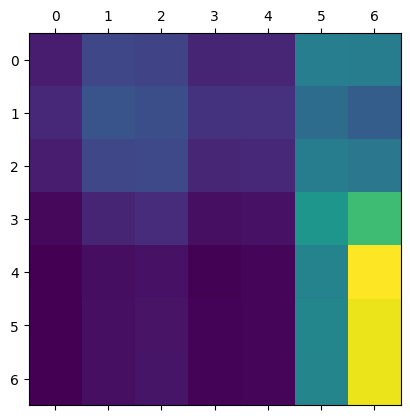

In [120]:
output_words, attentions = evaluate(encoder2, decoder2, "我不确定。")
output_sentence = ' '.join(output_words)
print(output_sentence)
plt.matshow(attentions.numpy())


In [121]:
# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + list(input_sentence) +
#                        ['<EOS>'], rotation=90)
#     ax.set_yticklabels([''] + output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()


# def evaluateAndShowAttention(input_sentence):
#     output_words, attentions = evaluate(encoder2, decoder2, input_sentence)
#     print('input =', input_sentence)
#     print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("我不确定。")


In [122]:
cn_vocab.get_stoi()['.']

312